In [1]:
import torch
from PIL import Image
import numpy as np
import pandas as pd
import torch
import os
import sys
from torch.utils import data
from sklearn.metrics import confusion_matrix as cm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('../')

from utils import utils, model_fetch, dataloader, calibration_utils
metrics_dict = {}

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Loading both test sets - CIFAR and CIFAR - 10H -- Images are same.

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# CIFAR Data
file_path = '../data/data-cifar-10/cifar-10-batches-py/test_batch'
label_dict = unpickle(file_path)
cifar_labels = label_dict[b'labels'] 

# Create PyTorch dataset for CIFAR images

data = label_dict[b'data'].reshape((10000, 3, 32, 32))
data= data.transpose((0,2,3,1))
dataset = dataloader.MyDataset(data, cifar_labels)

In [6]:
# Which model to evaluate


####### Change This #######
model_of_interest = "baseline"
###########################
_CLASSES = ['plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

base_path = '../distillation_experiments/runs/'

MODEL_DIRS = {
    "baseline_teacher": base_path + 'resnet18_baseline_retrained_1586751743/model_best.pth.tar',
    "mixup_teacher": base_path + 'resnet18_mixup_retrained_1586457991/checkpoint.pth.tar',
    "cutout_teacher": base_path + 'resnet18-cutout-restart-again_1586956477/model_best.pth.tar',
    "cutmix_teacher": base_path + 'resnet18_cutmix_retrained_1587147326-20200423T211700Z-001/model_best.pth.tar',
    "augmented_teacher": base_path + 'resnet18_augmented_retrained_1586751381/checkpoint.pth.tar',
    
    "baseline": base_path + 'student_baseline_retrained_temp20_gamma0.5_1587170761/checkpoint.pth.tar', 
    "mixup" : base_path + 'student_mixup_retrained_temp20_gamma0.5_1587170205/model_best.pth.tar',
    "cutout": base_path + 'lenet-student-cutout_1587345858/model_best.pth.tar',
    "cutmix": base_path + 'student_cutmix_temp20_gamma0.5_1587176582/model_best.pth.tar',
    "augmented": base_path + 'lenet-student-augmented-lr1e-4_1587576542/model_best.pth.tar',
    
    "baseline_alexnet": base_path + 'baseline_AlexNet_student_temp20_gamma0.5_1587675250/checkpoint.pth.tar', 
    "mixup_alexnet" : base_path + 'mixup_AlexNet_student_temp20_gamma0.5_1587693434/model_best.pth.tar',
    "cutout_alexnet": base_path + 'cutout_AlexNet_student_temp20_gamma0.5_1587783049/model_best.pth.tar',
    "cutmix_alexnet": base_path + 'cutmix_AlexNet_student2_temp20_gamma0.5_1587615309/model_best.pth.tar',
    "augmented_alexnet": base_path + 'augmentation_AlexNet_student_temp20_gamma0.5_1587656440/model_best.pth.tar'
}
if 'teacher' in model_of_interest:
    model = model_fetch.fetch_student('resnet18')
elif 'alexnet' in model_of_interest:
    model = model_fetch.fetch_student('alexnet')
else:
    model = model_fetch.fetch_student('lenet')

_, _ = utils.load_checkpoint(model, resume_filename=MODEL_DIRS[model_of_interest])
model.eval()

=> Loading Checkpoint '../distillation_experiments/runs/student_baseline_retrained_temp20_gamma0.5_1587170761/checkpoint.pth.tar'
Loaded checkpoint '../distillation_experiments/runs/student_baseline_retrained_temp20_gamma0.5_1587170761/checkpoint.pth.tar' (epoch 178)
Current Loss :  1.061001263087309


LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
# model_list = ["baseline_alexnet", "mixup_alexnet", "cutmix_alexnet", "augmented_alexnet", "cutout_alexnet"]

# model_list = ["baseline_teacher", "mixup_teacher", "cutmix_teacher", "augmented_teacher", "cutout_teacher"]
model_list = ["baseline", "mixup", "cutmix", "augmented", "cutout"]

elem_list = []

for i, model_name in enumerate(model_list):
    if 'teacher' in model_of_interest:
        model = model_fetch.fetch_student('resnet18')
    elif 'alexnet' in model_of_interest:
        model = model_fetch.fetch_student('alexnet')
    else:
        model = model_fetch.fetch_student('lenet')

    _, _ = utils.load_checkpoint(model, resume_filename=MODEL_DIRS[model_name])
    model = model.eval()
    preds_path =  '../../results/preds/' + model_name + '.npy'
    preds = np.load(preds_path)
    # True Labels
    y_true = np.array(cifar_labels)

    # Predicted y
    y_preds = np.argmax(preds, axis=1)
    y_confs = np.max(preds, axis=1)
    elem = calibration_utils.CalibrationError(y_confs, y_preds, y_true)
    nll = -np.log(max(y_confs))
    elem["NLL"] = nll
    elem_list.append(elem)

=> Loading Checkpoint '../distillation_experiments/runs/student_baseline_retrained_temp20_gamma0.5_1587170761/checkpoint.pth.tar'
Loaded checkpoint '../distillation_experiments/runs/student_baseline_retrained_temp20_gamma0.5_1587170761/checkpoint.pth.tar' (epoch 178)
Current Loss :  1.061001263087309
=> Loading Checkpoint '../distillation_experiments/runs/student_mixup_retrained_temp20_gamma0.5_1587170205/model_best.pth.tar'
Loaded checkpoint '../distillation_experiments/runs/student_mixup_retrained_temp20_gamma0.5_1587170205/model_best.pth.tar' (epoch 138)
Current Loss :  1.0498723033108288
=> Loading Checkpoint '../distillation_experiments/runs/student_cutmix_temp20_gamma0.5_1587176582/model_best.pth.tar'
Loaded checkpoint '../distillation_experiments/runs/student_cutmix_temp20_gamma0.5_1587176582/model_best.pth.tar' (epoch 250)
Current Loss :  1.088435726829722
=> Loading Checkpoint '../distillation_experiments/runs/lenet-student-augmented-lr1e-4_1587576542/model_best.pth.tar'
Loade

In [8]:
plt.style.use("seaborn")

Text(0, 0.5, 'Accuracy')

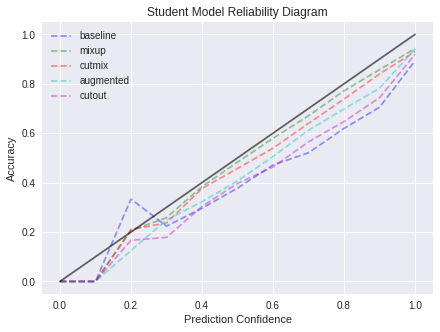

In [9]:
plt.figure(figsize=(7,5))
bline_x = bline_y = np.arange(0,1.1,0.1)
color_list = ['b', 'g', 'r', 'c', 'm']
alpha = 0.4
for i, elem in enumerate(elem_list):
    plt.plot(elem["Thresholds"], elem["Accuracies"], 
             c=color_list[i], alpha=alpha, label = model_list[i].split("_")[0] , 
             linestyle='dashed')
    
plt.plot(bline_x, bline_y, 'k', alpha=0.6)
plt.grid(True)
plt.legend()
if 'teacher' in model_name:
    plt.title("Teacher Model Reliability Diagram")
else:
    plt.title("Student Model Reliability Diagram")
    
plt.xlabel("Prediction Confidence")
plt.ylabel("Accuracy")

In [10]:
CE_df = {
    "MCE": {},
    "ECE": {},
    "NLL(Scaled)": {}
}
for i, model_name in enumerate(model_list):
    CE_df["ECE"][model_name] = elem_list[i]["ECE"]
    CE_df["MCE"][model_name] = elem_list[i]["MCE"]
    CE_df["NLL(Scaled)"][model_name] = elem_list[i]["NLL"] * 100
CE_dframe = pd.DataFrame(CE_df)
CE_dframe

,MCE,ECE,NLL(Scaled)
baseline,0.145870,0.096235,-0.000000
mixup,0.032865,0.020709,0.017901
cutmix,0.028097,0.015719,0.004363
augmented,0.069758,0.039545,0.000668
cutout,0.108279,0.073156,0.000107


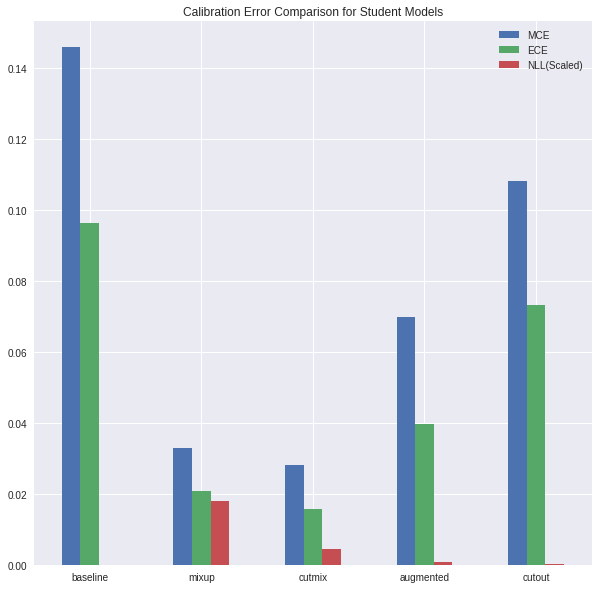

In [11]:
CE_dframe.plot(rot=0, kind='bar', figsize=(10,10), grid=True)
if "teacher" in model_name:
    plt.title("Calibration Error Comparison for Teacher Models")
else:
    plt.title("Calibration Error Comparison for Student Models")

In [50]:
Alexnet_metrics = {'MCE': {'baseline': 0.14886785528626856,
  'mixup': 0.1301652491092682,
  'cutmix': 0.06183631159365177,
  'augmented': 0.21035625972366856,
  'cutout': 0.24847220907024303},
 'ECE': {'baseline': 0.08090768114924429,
  'mixup': 0.00822673286646605,
  'cutmix': 0.014400043697655192,
  'augmented': 0.10043587629497053,
  'cutout': 0.11218914050012829},
 'NLL(Scaled)': {'baseline_alexnet': 0.1957159423828125,
  'mixup_alexnet': 0.406207275390625,
  'cutmix_alexnet': 0.366924365234375,
  'augmented_alexnet': 0.15623665771484374,
  'cutout_alexnet': 0.13101600341796876}}


Lenet_metrics = {'MCE': {'baseline': 0.14586952497469396,
  'mixup': 0.03286512832809646,
  'cutmix': 0.028096702656251332,
  'augmented': 0.06975753585758959,
  'cutout': 0.10827891772273202},
 'ECE': {'baseline': 0.09623522882014514,
  'mixup': 0.020708593660593022,
  'cutmix': 0.015719311952590947,
  'augmented': 0.039544983014464366,
  'cutout': 0.07315568645149471},
 'NLL(Scaled)': {'baseline': 0.3426241455078125,
  'mixup': 0.55806259765625,
  'cutmix': 0.539755810546875,
  'augmented': 0.461835791015625,
  'cutout': 0.3881336181640625}}


Teacher_metrics = {'MCE': {'baseline': 0.20502703999680172,
  'mixup': 0.17002828346332066,
  'cutmix': 0.25151829421520233,
  'augmented': 0.25474517047405243,
  'cutout': 0.2366832697332787},
 'ECE': {'baseline_teacher': 0.07627823758274316,
  'mixup_teacher': 0.12170226776599882,
  'cutmix_teacher': 0.005481521761417396,
  'augmented_teacher': 0.037971140941977496,
  'cutout_teacher': 0.07212993016541007},
 'NLL(Scaled)': {'baseline_teacher': 0.09192499389648437,
  'mixup_teacher': 0.3147435546875,
  'cutmix_teacher': 0.049376141357421875,
  'augmented_teacher': 0.026550408935546874,
  'cutout_teacher': 0.0606677001953125}}

In [57]:
metrics_dict = {
    "Teacher": Teacher_metrics["MCE"],
    "Student-LeNet": Lenet_metrics["MCE"],
    "Student-AlexNet": Alexnet_metrics["MCE"]
}
metrics_df = pd.DataFrame(metrics_dict)

In [85]:

ticks = ['baseline', 'cutout', 'augmented', 'cutmix', 'mixup']

teacher_mce = [Teacher_metrics['MCE'][tick] for tick in ticks]
lenet_mce = [Lenet_metrics['MCE'][tick] for tick in ticks]
alexnet_mce = [Alexnet_metrics['MCE'][tick] for tick in ticks]


teacher_min = [min(teacher_mce) for _ in range(5)]
lenet_min = [min(lenet_mce) for _ in range(5)]
alexnet_min = [min(alexnet_mce) for _ in range(5)]

Text(0.5, 1.0, 'ECE for different Teacher Student Models')

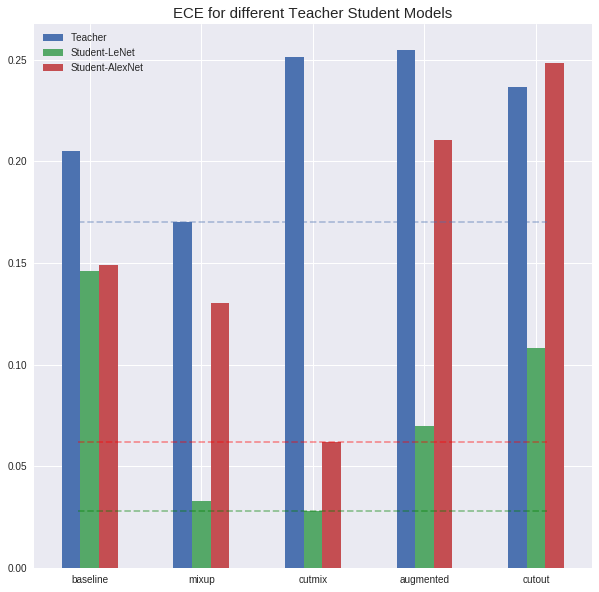

In [90]:
ax = metrics_df.plot(rot=0, kind='bar', figsize=(10,10), grid=True, xlim=(4, 9))
ax.plot([-0.1, 1.0, 2.0, 3.0, 4.1], teacher_min, linestyle='--', alpha=0.4)
ax.plot([-0.1, 1.0, 2.0, 3.0, 4.1], lenet_min, linestyle='--', color='g', alpha=0.4)
ax.plot([-0.1, 1.0, 2.0, 3.0, 4.1], alexnet_min, linestyle='--', color='r', alpha=0.4)
ax.set_title("ECE for different Teacher Student Models", size=15)

In [75]:
teacher_max

[0.17002828346332066,
 0.17002828346332066,
 0.17002828346332066,
 0.17002828346332066,
 0.17002828346332066,
 0.17002828346332066,
 0.17002828346332066]